In [73]:
import pandas as pd
import numpy as np
import pybaseball as pyb
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt, atan2, degrees, pi
from scipy.stats import percentileofscore
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

# This line ensures that the plots are displayed within the notebook
%matplotlib inline

pd.set_option('display.max_rows', None)

In [74]:
import pandas as pd #use pandas for reading in the query
import pyodbc as odbc #this package is for the database driver
from pandasql import sqldf #this is optional

#Create python connection for SQL
cnxn_str = ('Driver=SQL Server; Server=OPSDBOAK85.oaklandathletics.com; Database=mlb_stats; trusted_connection=true')

cnxn = odbc.connect(cnxn_str) #reads in the connection 


cursor = cnxn.cursor()

query = """
SELECT 
    pe.PitcherId,
    pl.NamePlayer,
    pe.PitHand,
    p.x0,
    p.y0,
    p.z0,
    p.vx0,
    p.vy0,
    p.vz0,
    p.ax,
    p.ay,
    p.az,
    p.PitchType,
    p.StartSpeed,
    p.SpinRate,
    p.Extension,
    p.ReleaseX,
    p.ReleaseZ,
    p.ReleaseAngle,
    p.ReleaseDirection,
    p.pz,
    p.px,
    pl.NameParentTeam,
    v.URL
FROM 
    mlb_stats.dbo.pbp_play_event AS pe
LEFT JOIN 
    mlb_stats.dbo.pbp_play_event_pitch AS p
    ON p.GamePk = pe.GamePk 
    AND p.PlayId = pe.PlayId
LEFT JOIN 
    mlb_stats.dbo.pbp_game AS g
    ON g.GamePk = pe.GamePk
LEFT JOIN 
    mlb_stats.dbo.mlb_roster_status AS pl
    ON pl.PlayerID = pe.PitcherId
LEFT JOIN 
    mlb_stats.dbo.pbp_play_event_video AS v
    ON v.GamePk = pe.GamePk 
    AND v.PlayId = pe.PlayId
WHERE 
    pe.IsPitch = 1  
    AND p.PitchType = 'FA' 
    AND p.StartSpeed >= 80
    AND YEAR(g.GameDate) = 2023
    AND pl.NameParentTeam = 'Oakland Athletics'
    AND g.GameType = 'R'
	AND v.Source = 'BROADCAST'
"""

OAK_fastballs=pd.read_sql(query,cnxn) 

C:\Users\jreydel\AppData\Local\Temp\ipykernel_1188\2118090839.py:65: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [75]:
import pandas as pd #use pandas for reading in the query
import pyodbc as odbc #this package is for the database driver
from pandasql import sqldf #this is optional

#Create python connection for SQL
cnxn_str = ('Driver=SQL Server; Server=OPSDBOAK85.oaklandathletics.com; Database=mlb_stats; trusted_connection=true')

cnxn = odbc.connect(cnxn_str) #reads in the connection 


cursor = cnxn.cursor()

query_complfb = """
SELECT [Name]
      ,[PlayerID]
      ,[Throws]
      ,[Level]
      ,[LeagueLevel]
      ,[Season]
      ,[SplitType]
      ,[PitchType]
      ,[TP]
      ,[Usage]
      ,[VeloAvg]
      ,[VeloMin]
      ,[VeloMax]
      ,[wAVG]
      ,[StrikeRate]
      ,[CalledStrikeRate]
      ,[InZone]
      ,[SwingRate]
      ,[Whiff]
      ,[InZoneWhiff]
      ,[OutZoneSwing]
      ,[HorzBreak]
      ,[VertIndBreak]
      ,[VAA]
      ,[Extension]
      ,[SpinRate]
      ,[SpinAxis]
      ,[SpinEff]
      ,[Tilt]
      ,[ReleaseX]
      ,[ReleaseZ]
      ,[ZValExp]
      ,[ZValObs]
      ,[StuffGrade]
      ,[StuffGradeSwing]
      ,[StuffPlus]
      ,[CommandPlus]
      ,[GBPer]
      ,[PUPer]
      ,[HitSpeedCt]
      ,[HitSpeed]
      ,[HitAngleV]
      ,[FirstGame]
      ,[LastGame]
      ,[UpdatedDate]
  FROM [mlb_stats].[dbo].[stat_pitcher_pitch]
  WHERE Season = 2023 AND PitchType = 'FA' AND SplitType = 'All' AND TP >= 75 AND CommandPlus IS NOT NULL
"""

OAK_Fastball_Command=pd.read_sql(query_complfb,cnxn) 

C:\Users\jreydel\AppData\Local\Temp\ipykernel_1188\1869510065.py:63: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [76]:
def calculate_vaa(row):
    yf = 17/12  # Home plate distance in feet, converted to inches
    ay = row['ay']  # Acceleration in y-dimension for the current pitch
    vy0 = row['vy0']  # Velocity in y-dimension at y=50 feet for the current pitch
    vz0 = row['vz0']  # Velocity in z-dimension at y=50 feet for the current pitch
    az = row['az']  # Acceleration in z-dimension for the current pitch

    vy_f = -sqrt(vy0**2 - (2 * ay * (50 - yf)))
    t = (vy_f - vy0) / ay
    vz_f = vz0 + (az * t)
    vaa_rad = atan2(vz_f, vy_f)
    vaa_deg = (180+degrees(vaa_rad))*-1

    return vaa_deg

In [77]:
def calculate_VRA(vy0, ay, release_extension, vz0, az):
    vy_s = -np.sqrt(vy0**2 - 2 * ay * (60.5 - release_extension - 50))
    t_s = (vy_s - vy0) / ay
    vz_s = vz0 - az * t_s
    VRA = -np.arctan(vz_s / vy_s) * (180 / np.pi)
    return VRA

def calculate_HRA(vy0, ay, release_extension, vx0, ax):
    vy_s = -np.sqrt(vy0**2 - 2 * ay * (60.5 - release_extension - 50))
    t_s = (vy_s - vy0) / ay
    vx_s = vx0 - ax * t_s
    HRA = -np.arctan(vx_s / vy_s) * (180 / np.pi)
    return HRA

In [78]:
OAK_fastballs['VAA'] = OAK_fastballs.apply(calculate_vaa, axis=1)

In [79]:
OAK_fastballs['VRA'] = OAK_fastballs.apply(lambda x: calculate_VRA(x['vy0'], x['ay'], x['Extension'], x['vz0'], x['az']), axis=1)
OAK_fastballs['HRA'] = OAK_fastballs.apply(lambda x: calculate_HRA(x['vy0'], x['ay'], x['Extension'], x['vx0'], x['ax']), axis=1)

In [80]:
pitch_count = OAK_fastballs['NamePlayer'].value_counts()

OAK_ff_filtered = OAK_fastballs[OAK_fastballs['NamePlayer'].isin(pitch_count.index[pitch_count >= 180])]

In [81]:
grouped_ff = OAK_ff_filtered.groupby(['NamePlayer', 'PitcherId']).agg({
    'VRA': 'std',
    'HRA': 'std',
    'ReleaseX': 'std',
    'ReleaseZ': 'std',
}).reset_index()  

#grouped_ff.rename(columns={'type': 'strike_rate'}, inplace=True)
weights = {'VRA_degrees': 0.42, 'HRA_degrees': 0.27, 'ReleaseZ': 0.17, 'ReleaseX': 0.14}

grouped_ff['VRA_percentile'] = 1 - grouped_ff['VRA'].rank(pct=True)
grouped_ff['HRA_percentile'] = 1 - grouped_ff['HRA'].rank(pct=True)
grouped_ff['release_pos_z_percentile'] = 1 - grouped_ff['ReleaseZ'].rank(pct=True)
grouped_ff['release_pos_x_percentile'] = 1 - grouped_ff['ReleaseX'].rank(pct=True)

grouped_ff['kirby_index'] = (
    grouped_ff['VRA_percentile'] * weights['VRA_degrees'] +
    grouped_ff['HRA_percentile'] * weights['HRA_degrees'] +
    grouped_ff['release_pos_z_percentile'] * weights['ReleaseZ'] +
    grouped_ff['release_pos_x_percentile'] * weights['ReleaseX']
)

OAK_ranked_pitchers_weighted_ff = grouped_ff.sort_values('kirby_index', ascending=False)

In [82]:
OAK_filtered_fastball_command = OAK_Fastball_Command.loc[:, ['PlayerID', 'StrikeRate', 'CalledStrikeRate', 'CommandPlus', 'InZone']]
OAK_full_fb_command = pd.merge(OAK_ranked_pitchers_weighted_ff, OAK_filtered_fastball_command, how='left', left_on='PitcherId', right_on='PlayerID')
OAK_full_fb_command_unique = OAK_full_fb_command.drop_duplicates(subset=['NamePlayer'])

from IPython.display import display

display(OAK_full_fb_command_unique)

,NamePlayer,PitcherId,VRA,HRA,ReleaseX,ReleaseZ,VRA_percentile,HRA_percentile,release_pos_z_percentile,release_pos_x_percentile,kirby_index,PlayerID,StrikeRate,CalledStrikeRate,CommandPlus,InZone
0,Ross Stripling,548389,0.910280,0.627953,0.123737,0.083562,0.644068,0.983051,0.966102,0.966102,0.835424,548389,0.678100,0.195251,55,0.456464
1,Seth Elledge,676220,0.822413,0.799002,0.133908,0.165839,0.915254,0.779661,0.084746,0.932203,0.739831,676220,0.653451,0.176211,50,0.540382
2,Gerardo Reyes,622103,0.881674,0.790146,0.205532,0.113991,0.779661,0.813559,0.677966,0.491525,0.731186,622103,0.661765,0.122549,40,0.529412
4,Robert Dugger,667498,0.901157,0.767024,0.161675,0.125529,0.694915,0.932203,0.491525,0.728814,0.729153,667498,0.626886,0.148148,55,0.481481
5,Joey Estes,683155,0.844198,0.806432,0.189661,0.126453,0.864407,0.694915,0.474576,0.593220,0.714407,683155,0.696970,0.150393,55,0.507295
8,JP Sears,676664,0.878916,0.823209,0.108290,0.129565,0.813559,0.576271,0.440678,0.983051,0.709831,676664,0.642559,0.136300,60,0.493046
9,Osvaldo Bido,674370,0.831408,0.936009,0.154103,0.086981,0.881356,0.203390,0.949153,0.864407,0.707458,674370,0.598291,0.113960,35,0.415954
11,Domingo Robles,660781,0.811651,0.786423,0.228727,0.165959,0.932203,0.847458,0.067797,0.389831,0.686441,660781,0.715909,0.211039,60,0.613636
12,Jack Cushing,681007,0.873600,0.706289,0.231259,0.161221,0.830508,0.966102,0.118644,0.372881,0.682034,681007,0.744912,0.170963,50,0.561737
14,Trevor Gott,641627,0.889304,0.888486,0.160200,0.100269,0.745763,0.305085,0.847458,0.745763,0.644068,641627,0.633803,0.145540,50,0.450704


In [83]:
OAK_select = OAK_full_fb_command_unique.loc[:, ['NamePlayer', 'StrikeRate', 'InZone', 'CommandPlus', 'kirby_index']]
display(OAK_select)

,NamePlayer,StrikeRate,InZone,CommandPlus,kirby_index
0,Ross Stripling,0.678100,0.456464,55,0.835424
1,Seth Elledge,0.653451,0.540382,50,0.739831
2,Gerardo Reyes,0.661765,0.529412,40,0.731186
4,Robert Dugger,0.626886,0.481481,55,0.729153
5,Joey Estes,0.696970,0.507295,55,0.714407
8,JP Sears,0.642559,0.493046,60,0.709831
9,Osvaldo Bido,0.598291,0.415954,35,0.707458
11,Domingo Robles,0.715909,0.613636,60,0.686441
12,Jack Cushing,0.744912,0.561737,50,0.682034
14,Trevor Gott,0.633803,0.450704,50,0.644068


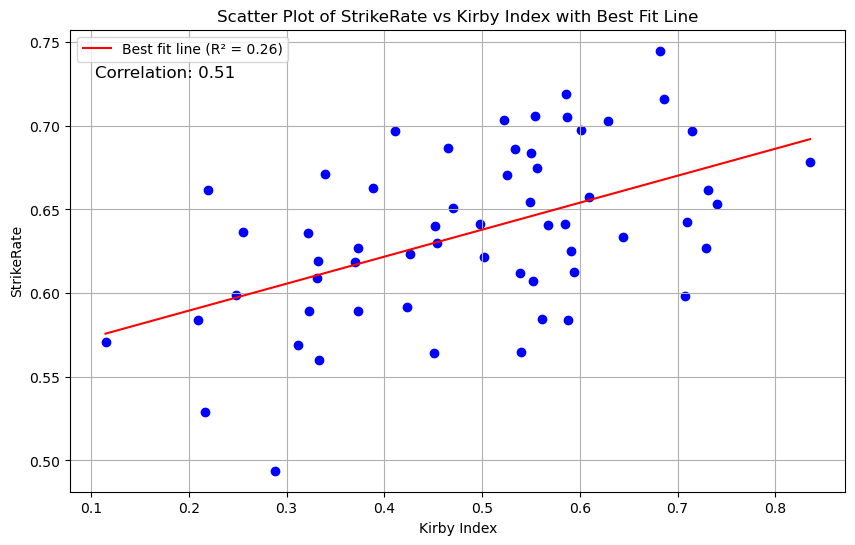

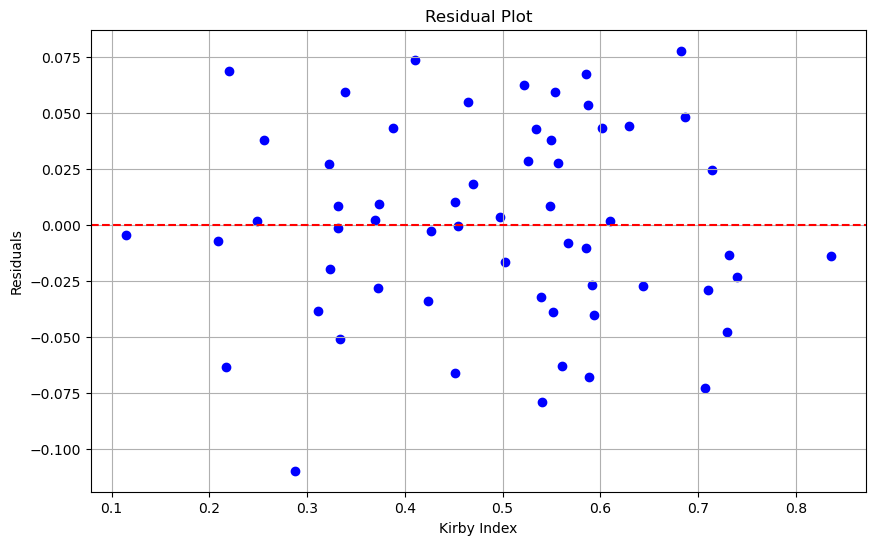

,kirby_index,InZone,Residual
0,0.835424,0.678100,-0.013954
1,0.739831,0.653451,-0.023179
2,0.731186,0.661765,-0.013470
4,0.729153,0.626886,-0.048020
5,0.714407,0.696970,0.024443
8,0.709831,0.642559,-0.029230
9,0.707458,0.598291,-0.073115
11,0.686441,0.715909,0.047895
12,0.682034,0.744912,0.077608
14,0.644068,0.633803,-0.027374


In [84]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

%matplotlib inline

# Ensure the merged DataFrame has the required columns
if 'StrikeRate' in OAK_select.columns and 'kirby_index' in OAK_select.columns:
    # Extract the relevant columns
    x = OAK_select['kirby_index']
    y = OAK_select['StrikeRate']

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Calculate the line of best fit
    line = slope * x + intercept

     # Calculate residuals
    residuals = y - line

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', marker='o')
    plt.plot(x, line, color='red', label=f'Best fit line (R² = {r_value**2:.2f})')

    # Add titles and labels
    plt.title('Scatter Plot of StrikeRate vs Kirby Index with Best Fit Line')
    plt.xlabel('Kirby Index')
    plt.ylabel('StrikeRate')
    plt.grid(True)
    plt.legend()

    # Display correlation
    correlation = x.corr(y)
    plt.figtext(0.15, 0.8, f'Correlation: {correlation:.2f}', fontsize=12, color='black')

    # Show the plot
    plt.show()
      
    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(x, residuals, c='blue', marker='o')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Kirby Index')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

    # Display first few residuals for inspection
    residuals_df = pd.DataFrame({'kirby_index': x, 'InZone': y, 'Residual': residuals})
    display(residuals_df)
else:
    print("Required columns 'StrikeRate' and 'kirby_index' are not present in the DataFrame.")

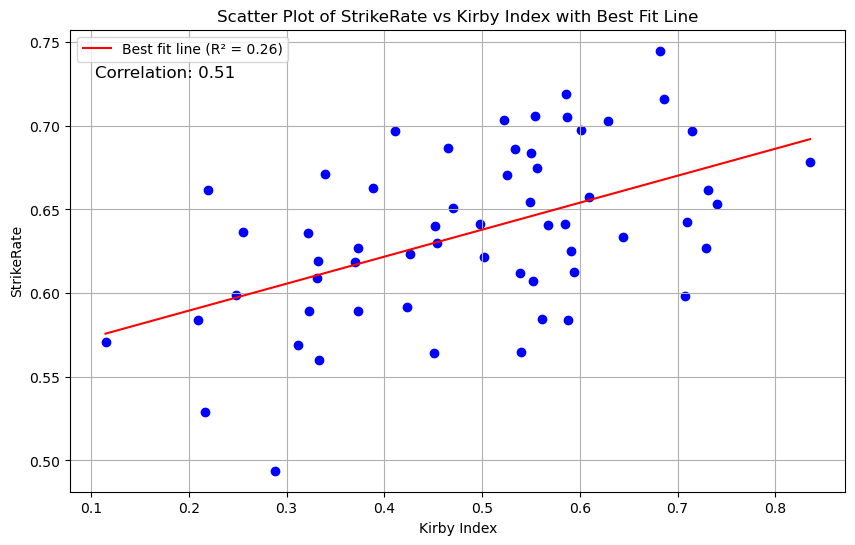

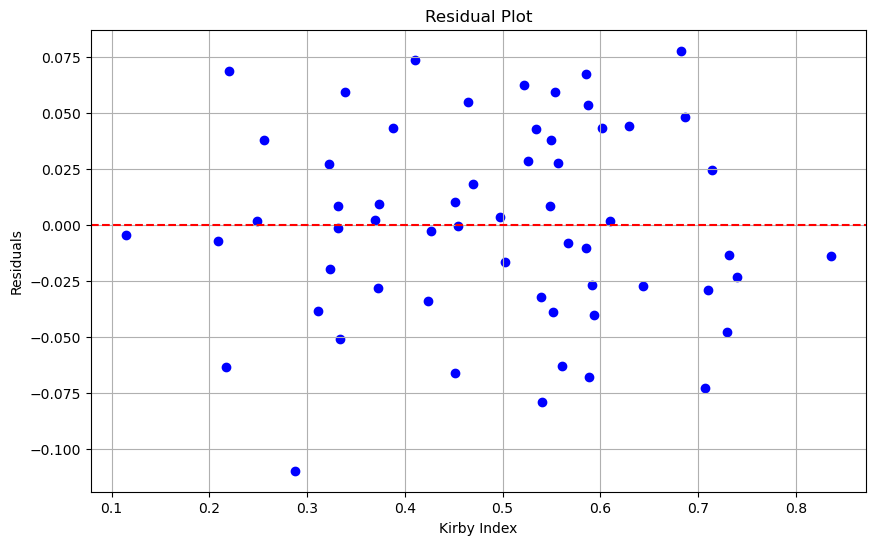

,kirby_index,InZone,Residual
0,0.835424,0.678100,-0.013954
1,0.739831,0.653451,-0.023179
2,0.731186,0.661765,-0.013470
4,0.729153,0.626886,-0.048020
5,0.714407,0.696970,0.024443
8,0.709831,0.642559,-0.029230
9,0.707458,0.598291,-0.073115
11,0.686441,0.715909,0.047895
12,0.682034,0.744912,0.077608
14,0.644068,0.633803,-0.027374


In [85]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Ensure the merged DataFrame has the required columns
if 'StrikeRate' in OAK_select.columns and 'kirby_index' in OAK_select.columns:
    # Extract the relevant columns
    x = OAK_select['kirby_index']
    y = OAK_select['StrikeRate']

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Calculate the line of best fit
    line = slope * x + intercept

     # Calculate residuals
    residuals = y - line

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', marker='o')
    plt.plot(x, line, color='red', label=f'Best fit line (R² = {r_value**2:.2f})')

    # Add titles and labels
    plt.title('Scatter Plot of StrikeRate vs Kirby Index with Best Fit Line')
    plt.xlabel('Kirby Index')
    plt.ylabel('StrikeRate')
    plt.grid(True)
    plt.legend()

    # Display correlation
    correlation = x.corr(y)
    plt.figtext(0.15, 0.8, f'Correlation: {correlation:.2f}', fontsize=12, color='black')

    # Show the plot
    plt.show()
      
    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(x, residuals, c='blue', marker='o')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Kirby Index')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

    # Display first few residuals for inspection
    residuals_df = pd.DataFrame({'kirby_index': x, 'InZone': y, 'Residual': residuals})
    display(residuals_df)
else:
    print("Required columns 'StrikeRate' and 'kirby_index' are not present in the DataFrame.")

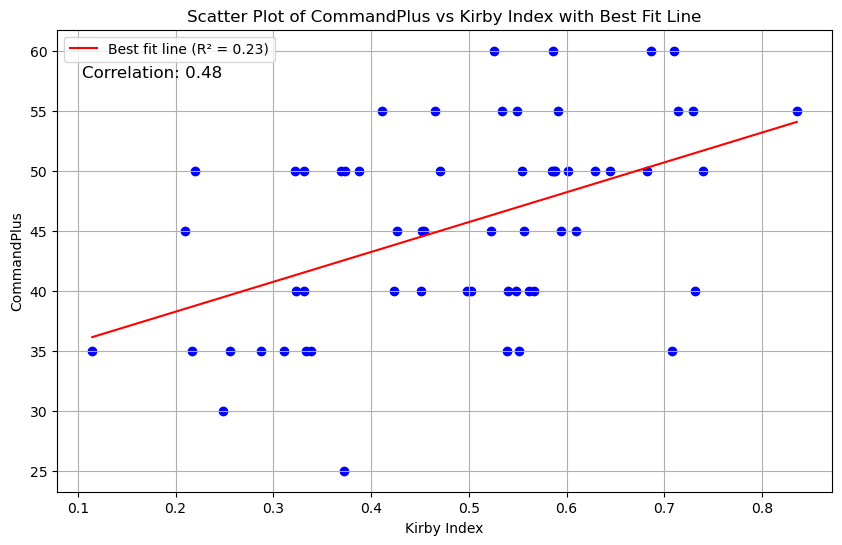

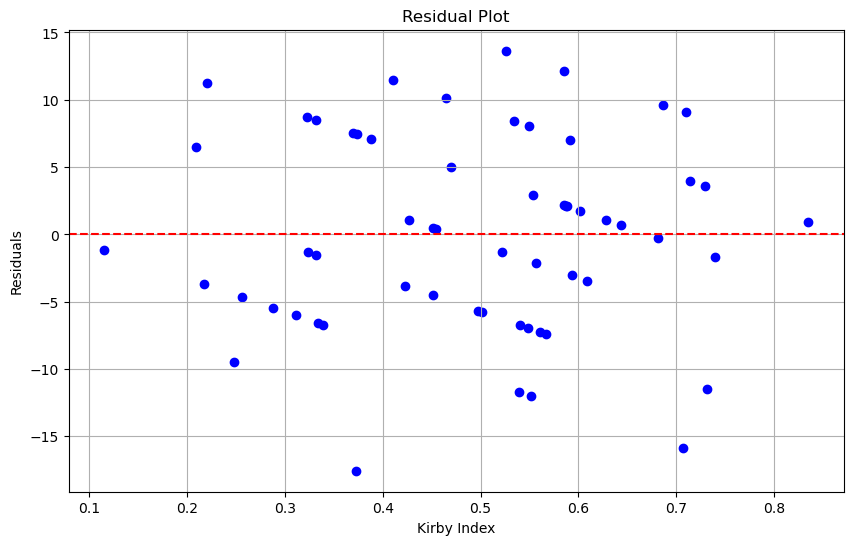

,kirby_index,InZone,Residual
0,0.835424,55,0.934644
1,0.739831,50,-1.686804
2,0.731186,40,-11.471723
4,0.729153,55,3.578885
5,0.714407,55,3.945789
8,0.709831,60,9.059656
9,0.707458,35,-15.881302
11,0.686441,60,9.641642
12,0.682034,50,-0.248708
14,0.644068,50,0.695964


In [86]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Ensure the merged DataFrame has the required columns
if 'StrikeRate' in OAK_select.columns and 'kirby_index' in OAK_select.columns:
    # Extract the relevant columns
    x = OAK_select['kirby_index']
    y = OAK_select['CommandPlus']

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Calculate the line of best fit
    line = slope * x + intercept

     # Calculate residuals
    residuals = y - line

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', marker='o')
    plt.plot(x, line, color='red', label=f'Best fit line (R² = {r_value**2:.2f})')

    # Add titles and labels
    plt.title('Scatter Plot of CommandPlus vs Kirby Index with Best Fit Line')
    plt.xlabel('Kirby Index')
    plt.ylabel('CommandPlus')
    plt.grid(True)
    plt.legend()

    # Display correlation
    correlation = x.corr(y)
    plt.figtext(0.15, 0.8, f'Correlation: {correlation:.2f}', fontsize=12, color='black')

    # Show the plot
    plt.show()
     
    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(x, residuals, c='blue', marker='o')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Kirby Index')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

    # Display first few residuals for inspection
    residuals_df = pd.DataFrame({'kirby_index': x, 'InZone': y, 'Residual': residuals})
    display(residuals_df)
else:
    print("Required columns 'StrikeRate' and 'kirby_index' are not present in the DataFrame.")
    

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Set the environment variable to avoid the memory leak warning
os.environ['OMP_NUM_THREADS'] = '2'

# Define the maximum number of clusters
max_clusters = 10

# Function to find the optimal number of clusters with silhouette score calculation
def find_optimal_clusters_with_silhouette(data, max_clusters):
    inertia = []
    silhouette_scores = []
    K_range = range(3, max_clusters + 1)  # Silhouette score is undefined for k=1
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(data)
        inertia.append(kmeans.inertia_)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)
    
    return inertia, silhouette_scores

# Store the results
results = []

# Iterate over each player
players = OAK_ff_filtered['NamePlayer'].unique()
for player in players:
    # Filter for player's fastballs
    player_data = OAK_ff_filtered[OAK_ff_filtered['NamePlayer'] == player]
    
    # Ensure there are no missing values in 'HRA' and 'VRA' columns
    player_data = player_data.dropna(subset=['HRA', 'VRA'])
    
    # Prepare the data for clustering
    X = player_data[['HRA', 'VRA']]
    
    if not X.empty:
        # Find the optimal number of clusters and calculate silhouette scores
        inertia, silhouette_scores = find_optimal_clusters_with_silhouette(X, max_clusters)
        
        # Find the optimal number of clusters with the highest silhouette score
        optimal_clusters = range(3, max_clusters + 1)[np.argmax(silhouette_scores)]
        
        # Append the result
        results.append({'Player': player, 'Optimal Clusters': optimal_clusters, 'Inertia': inertia[np.argmax(silhouette_scores)], 'Silhouette Score': max(silhouette_scores)})

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a m

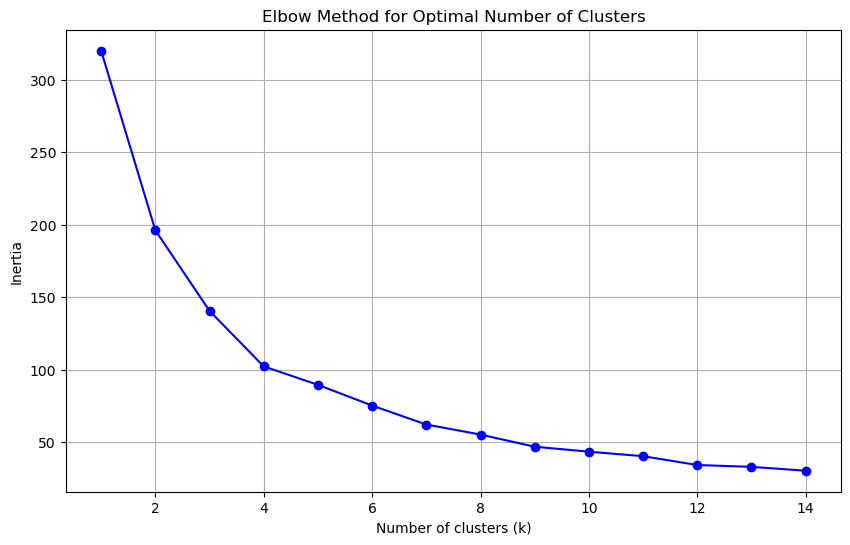

In [87]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import mplcursors

# Filter for player fastballs
OAK_ff_player_HRA_VRA_CL = OAK_ff_filtered[OAK_ff_filtered['NamePlayer'] == 'Blaze Pontes']

# Ensure there are no missing values in 'HRA' and 'VRA' columns
OAK_ff_player_HRA_VRA_CL = OAK_ff_player_HRA_VRA_CL.dropna(subset=['HRA', 'VRA'])

# Prepare the data for clustering
X = OAK_ff_player_HRA_VRA_CL[['HRA', 'VRA']]

# Perform K-means clustering for a range of cluster numbers and calculate inertia
inertia = []
K_range = range(1, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow method result
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



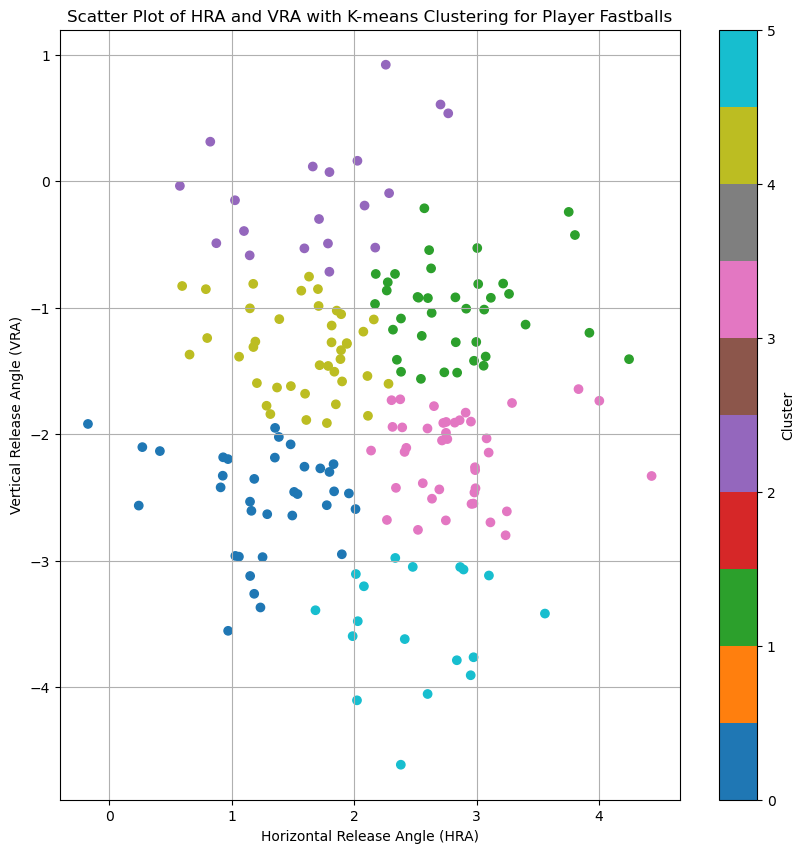

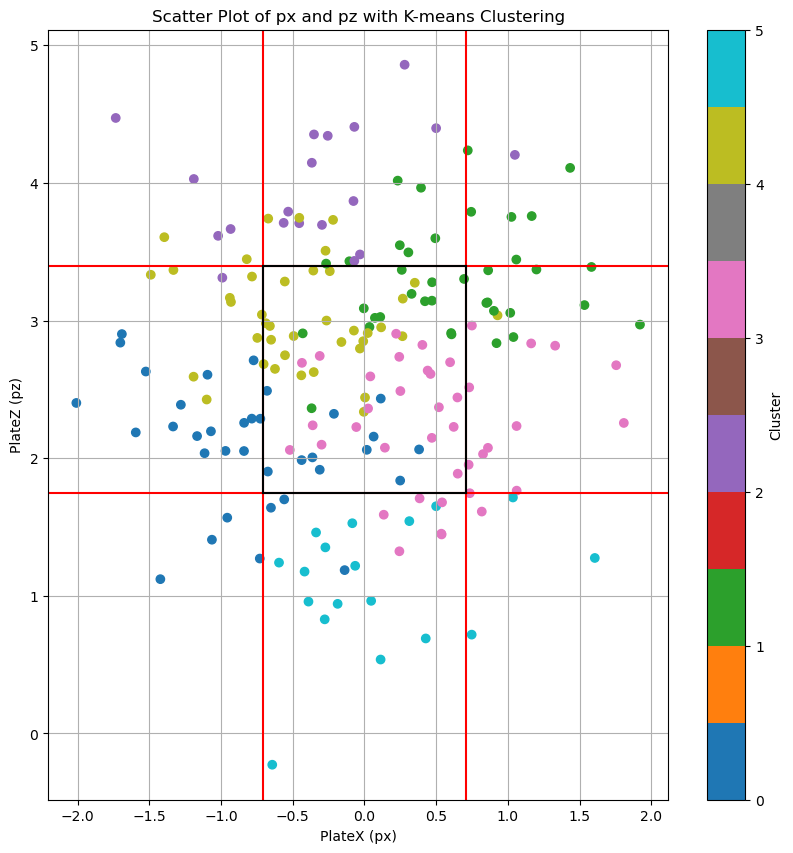

In [88]:
# Perform K-means clustering

# Enter Number of Clusters here 
kmeans = KMeans(n_clusters=6, random_state=4).fit(X)
OAK_ff_player_HRA_VRA_CL['cluster'] = kmeans.labels_

# Scatter plot for HRA and VRA
fig1, ax1 = plt.subplots(figsize=(10, 10))
sc1 = ax1.scatter(OAK_ff_player_HRA_VRA_CL['HRA'], OAK_ff_player_HRA_VRA_CL['VRA'], 
                  c=OAK_ff_player_HRA_VRA_CL['cluster'], cmap='tab10', marker='o')
ax1.set_title('Scatter Plot of HRA and VRA with K-means Clustering for Player Fastballs')
ax1.set_xlabel('Horizontal Release Angle (HRA)')
ax1.set_ylabel('Vertical Release Angle (VRA)')
ax1.grid(True)
plt.colorbar(sc1, ax=ax1, label='Cluster')

# Add cursor functionality
cursor1 = mplcursors.cursor(sc1, hover=True)
@cursor1.connect("add")
def on_add1(sel):
    index = sel.target.index
    sel.annotation.set_text(f"URL: {OAK_ff_player_HRA_VRA_CL.iloc[index]['URL']}")

plt.show()

# Scatter plot for px and pz
fig2, ax2 = plt.subplots(figsize=(10, 10))
sc2 = ax2.scatter(OAK_ff_player_HRA_VRA_CL['px'], OAK_ff_player_HRA_VRA_CL['pz'], 
                  c=OAK_ff_player_HRA_VRA_CL['cluster'], cmap='tab10', marker='o')
ax2.set_title('Scatter Plot of px and pz with K-means Clustering')
ax2.set_xlabel('PlateX (px)')
ax2.set_ylabel('PlateZ (pz)')
ax2.grid(True)
plt.colorbar(sc2, ax=ax2, label='Cluster')
ax2.axvline(x=0.7083, color='r', linestyle='-')
ax2.axvline(x=-0.7083, color='r', linestyle='-')
ax2.axhline(y=1.75, color='r', linestyle='-')
ax2.axhline(y=3.4, color='r', linestyle='-')

# Add the box
ax2.plot([-0.7083, 0.7083], [1.75, 1.75], color='black')
ax2.plot([-0.7083, 0.7083], [3.4, 3.4], color='black')
ax2.plot([-0.7083, -0.7083], [1.75, 3.4], color='black')
ax2.plot([0.7083, 0.7083], [1.75, 3.4], color='black')

# Add cursor functionality
cursor2 = mplcursors.cursor(sc2, hover=True)
@cursor2.connect("add")
def on_add2(sel):
    index = sel.target.index
    sel.annotation.set_text(f"URL: {OAK_ff_player_HRA_VRA_CL.iloc[index]['URL']}")

plt.show()

In [89]:
#App with video

import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
from sklearn.cluster import KMeans
import pandas as pd


# Filter for player fastballs
OAK_ff_player_HRA_VRA_CL = OAK_ff_filtered[OAK_ff_filtered['NamePlayer'] == 'Blaze Pontes']

# Ensure there are no missing values in 'HRA' and 'VRA' columns
OAK_ff_player_HRA_VRA_CL = OAK_ff_player_HRA_VRA_CL.dropna(subset=['HRA', 'VRA'])

# Prepare the data for clustering
X = OAK_ff_player_HRA_VRA_CL[['HRA', 'VRA']]

# Perform K-means clustering
kmeans = KMeans(n_clusters=9, random_state=4).fit(X)
OAK_ff_player_HRA_VRA_CL['cluster'] = kmeans.labels_

# Create the Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    dcc.Graph(id='scatter-hra-vra'),
    dcc.Graph(id='scatter-px-pz'),
    dcc.Location(id='url', refresh=True)
])

# Callback to update the scatter plot for HRA and VRA
@app.callback(
    Output('scatter-hra-vra', 'figure'),
    Input('scatter-hra-vra', 'clickData')
)
def update_hra_vra(clickData):
    fig1 = px.scatter(OAK_ff_player_HRA_VRA_CL, x='HRA', y='VRA', color='cluster',
                      title='Scatter Plot of HRA and VRA with K-means Clustering for Player Fastballs',
                      labels={'HRA': 'Horizontal Release Angle (HRA)', 'VRA': 'Vertical Release Angle (VRA)'},
                      hover_data=['URL'])
    fig1.update_layout(coloraxis_colorbar=dict(title='Cluster'))
    fig1.update_traces(marker=dict(size=10))
    return fig1

# Callback to update the scatter plot for px and pz
@app.callback(
    Output('scatter-px-pz', 'figure'),
    Input('scatter-px-pz', 'clickData')
)
def update_px_pz(clickData):
    fig2 = px.scatter(OAK_ff_player_HRA_VRA_CL, x='px', y='pz', color='cluster',
                      title='Scatter Plot of px and pz with K-means Clustering',
                      labels={'px': 'PlateX (px)', 'pz': 'PlateZ (pz)'},
                      hover_data=['URL'])
    fig2.update_layout(coloraxis_colorbar=dict(title='Cluster'))
    fig2.update_traces(marker=dict(size=10))
    
    fig2.add_shape(type='line', x0=0.7083, x1=0.7083, y0=1.75, y1=3.4, line=dict(color='Red'))
    fig2.add_shape(type='line', x0=-0.7083, x1=-0.7083, y0=1.75, y1=3.4, line=dict(color='Red'))
    fig2.add_shape(type='line', x0=-0.7083, x1=0.7083, y0=1.75, y1=1.75, line=dict(color='Red'))
    fig2.add_shape(type='line', x0=-0.7083, x1=0.7083, y0=3.4, y1=3.4, line=dict(color='Red'))
    fig2.add_shape(type='rect', x0=-0.7083, x1=0.7083, y0=1.75, y1=3.4, line=dict(color='Black'))
    
    return fig2

# Callback to handle URL redirection for both graphs
@app.callback(
    Output('url', 'href'),
    [Input('scatter-hra-vra', 'clickData'),
     Input('scatter-px-pz', 'clickData')]
)
def redirect_url(clickDataHraVra, clickDataPxPz):
    context = dash.callback_context

    if not context.triggered:
        return dash.no_update

    triggered_id = context.triggered[0]['prop_id'].split('.')[0]

    if triggered_id == 'scatter-hra-vra' and clickDataHraVra:
        point_index = clickDataHraVra['points'][0]['pointIndex']
        url = OAK_ff_player_HRA_VRA_CL.iloc[point_index]['URL']
        return url
    elif triggered_id == 'scatter-px-pz' and clickDataPxPz:
        point_index = clickDataPxPz['points'][0]['pointIndex']
        url = OAK_ff_player_HRA_VRA_CL.iloc[point_index]['URL']
        return url
    return dash.no_update

# Open a web browser tab with the app URL
def open_browser():
    import webbrowser
    webbrowser.open_new_tab("http://127.0.0.1:8062/")

# Run the app
if __name__ == '__main__':
    open_browser()
    app.run_server(debug=True, port=8062)


c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a m

In [71]:
results_df.rename(columns={'Player': 'NamePlayer'}, inplace=True)

# Merge results_df onto OAK_select
OAK_full_fb_w_optimal_clusters = pd.merge(OAK_full_fb_command_unique, results_df, how='left', on='NamePlayer')

columns_to_drop = ['VRA', 'HRA', 'ReleaseX', 'ReleaseZ', 'PlayerID', 'Inertia']
OAK_full_fb_w_optimal_clusters = OAK_full_fb_w_optimal_clusters.drop(columns=columns_to_drop)

display(OAK_full_fb_w_optimal_clusters)

,NamePlayer,PitcherId,VRA_percentile,HRA_percentile,release_pos_z_percentile,release_pos_x_percentile,kirby_index,StrikeRate,CalledStrikeRate,CommandPlus,InZone,Optimal Clusters,Silhouette Score
0,Ross Stripling,548389,0.644068,0.983051,0.966102,0.966102,0.835424,0.678100,0.195251,55,0.456464,10,0.378565
1,Seth Elledge,676220,0.915254,0.779661,0.084746,0.932203,0.739831,0.653451,0.176211,50,0.540382,5,0.340391
2,Gerardo Reyes,622103,0.779661,0.813559,0.677966,0.491525,0.731186,0.661765,0.122549,40,0.529412,9,0.351986
3,Robert Dugger,667498,0.694915,0.932203,0.491525,0.728814,0.729153,0.626886,0.148148,55,0.481481,4,0.345656
4,Joey Estes,683155,0.864407,0.694915,0.474576,0.593220,0.714407,0.696970,0.150393,55,0.507295,9,0.336465
5,JP Sears,676664,0.813559,0.576271,0.440678,0.983051,0.709831,0.642559,0.136300,60,0.493046,3,0.333014
6,Osvaldo Bido,674370,0.881356,0.203390,0.949153,0.864407,0.707458,0.598291,0.113960,35,0.415954,10,0.328238
7,Domingo Robles,660781,0.932203,0.847458,0.067797,0.389831,0.686441,0.715909,0.211039,60,0.613636,8,0.338509
8,Jack Cushing,681007,0.830508,0.966102,0.118644,0.372881,0.682034,0.744912,0.170963,50,0.561737,4,0.338618
9,Trevor Gott,641627,0.745763,0.305085,0.847458,0.745763,0.644068,0.633803,0.145540,50,0.450704,6,0.371063
